<a href="https://colab.research.google.com/github/namuduris/Prediction-of-Health-Insurance-Using-ML/blob/main/Health_Insurance11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   age   bmi  smoker  blood_pressure  cholesterol  glucose  family_history  \
0   56  25.0       1             111          155      132               0   
1   46  36.0       1             137          294      189               1   
2   32  24.0       0             140          223      105               0   
3   60  33.0       0              92          263       77               0   
4   25  35.0       1             131          176      138               0   

   diabetes_risk  cvd_risk  cancer_risk  insurance_cost  
0              0         1            1    76051.073141  
1              1         1            1   105443.712109  
2              0         1            0    75109.671634  
3              0         0            0    71126.420767  
4              0         1            1    77566.818698  
Diabetes Accuracy: 0.9
Diabetes AUC: 0.9616268382352942
CVD Accuracy: 0.855
CVD AUC: 0.9320987654320987
Cancer Accuracy: 0.875
Cancer AUC: 0.9299038350133241
Best Parameters: {'subsam

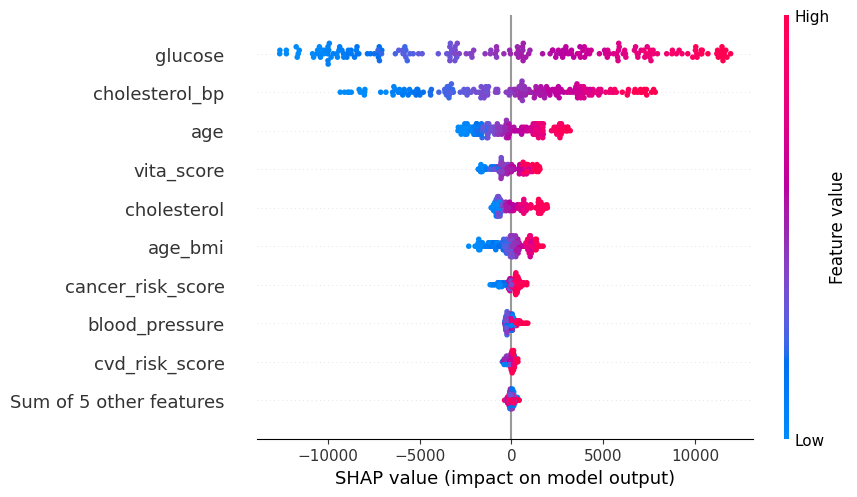

Predicted Insurance Cost for new user: 67501.69


In [2]:
# Step 1: Install Required Libraries
# pip install xgboost pandas scikit-learn shap matplotlib

# Step 2: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt

# Step 3: Load and Preprocess Data
data = pd.read_csv('health_insurance.csv')
print(data.head())

# Define target
y = data['insurance_cost']

# Feature Engineering
data['age_bmi'] = data['age'] * data['bmi']
data['smoker_bmi'] = data['smoker'] * data['bmi']
data['cholesterol_bp'] = data['cholesterol'] * data['blood_pressure']

# Step 4: Disease Risk Models
# Diabetes
X_diabetes = data[['age', 'bmi', 'glucose', 'family_history']]
y_diabetes = data['diabetes_risk']
X_train_dia, X_test_dia, y_train_dia, y_test_dia = train_test_split(X_diabetes, y_diabetes, test_size=0.2, random_state=42)
diabetes_model = LogisticRegression(max_iter=1000)
diabetes_model.fit(X_train_dia, y_train_dia)
print("Diabetes Accuracy:", accuracy_score(y_test_dia, diabetes_model.predict(X_test_dia)))
print("Diabetes AUC:", roc_auc_score(y_test_dia, diabetes_model.predict_proba(X_test_dia)[:, 1]))

# CVD
X_cvd = data[['age', 'bmi', 'blood_pressure', 'cholesterol', 'smoker']]
y_cvd = data['cvd_risk']
X_train_cvd, X_test_cvd, y_train_cvd, y_test_cvd = train_test_split(X_cvd, y_cvd, test_size=0.2, random_state=42)
cvd_model = LogisticRegression(max_iter=1000)
cvd_model.fit(X_train_cvd, y_train_cvd)
print("CVD Accuracy:", accuracy_score(y_test_cvd, cvd_model.predict(X_test_cvd)))
print("CVD AUC:", roc_auc_score(y_test_cvd, cvd_model.predict_proba(X_test_cvd)[:, 1]))

# Cancer
X_cancer = data[['age', 'bmi', 'smoker', 'family_history']]
y_cancer = data['cancer_risk']
X_train_can, X_test_can, y_train_can, y_test_can = train_test_split(X_cancer, y_cancer, test_size=0.2, random_state=42)
cancer_model = LogisticRegression(max_iter=1000)
cancer_model.fit(X_train_can, y_train_can)
print("Cancer Accuracy:", accuracy_score(y_test_can, cancer_model.predict(X_test_can)))
print("Cancer AUC:", roc_auc_score(y_test_can, cancer_model.predict_proba(X_test_can)[:, 1]))

# Add Disease Risk Predictions
data['diabetes_risk_score'] = diabetes_model.predict_proba(X_diabetes)[:, 1]
data['cvd_risk_score'] = cvd_model.predict_proba(X_cvd)[:, 1]
data['cancer_risk_score'] = cancer_model.predict_proba(X_cancer)[:, 1]

# Composite VITA Score
data['vita_score'] = (
    0.4 * data['diabetes_risk_score'] +
    0.35 * data['cvd_risk_score'] +
    0.25 * data['cancer_risk_score']
)

# Final feature set
X = data.drop(['insurance_cost', 'diabetes_risk', 'cvd_risk', 'cancer_risk'], axis=1)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

model = XGBRegressor(objective='reg:squarederror', random_state=42)
search = RandomizedSearchCV(model, param_grid, cv=5, scoring='r2', n_iter=25, n_jobs=-1)
search.fit(X_train, y_train)

# Step 6: Evaluate Final Model
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Best Parameters:", search.best_params_)
print(f"Test MSE: {mse:.2f}")
print(f"Test R^2: {r2:.4f}")

# Cross-Validation Score
cv_scores = cross_val_score(best_model, X, y, scoring='r2', cv=5)
print("Cross-validated R^2:", np.mean(cv_scores))

# Step 7: SHAP Explainability
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

# Step 8: Predict on New Sample
new_data = pd.DataFrame({
    'age': [47],
    'bmi': [21],
    'smoker': [0],
    'blood_pressure': [122],
    'cholesterol': [188],
    'glucose': [90],
    'family_history': [0],
})

# Interaction features
new_data['age_bmi'] = new_data['age'] * new_data['bmi']
new_data['smoker_bmi'] = new_data['smoker'] * new_data['bmi']
new_data['cholesterol_bp'] = new_data['cholesterol'] * new_data['blood_pressure']

# Disease risks
new_data['diabetes_risk_score'] = diabetes_model.predict_proba(new_data[['age', 'bmi', 'glucose', 'family_history']])[:, 1]
new_data['cvd_risk_score'] = cvd_model.predict_proba(new_data[['age', 'bmi', 'blood_pressure', 'cholesterol', 'smoker']])[:, 1]
new_data['cancer_risk_score'] = cancer_model.predict_proba(new_data[['age', 'bmi', 'smoker', 'family_history']])[:, 1]

# VITA Score
new_data['vita_score'] = (
    0.4 * new_data['diabetes_risk_score'] +
    0.35 * new_data['cvd_risk_score'] +
    0.25 * new_data['cancer_risk_score']
)

# Predict insurance cost
predicted_cost = best_model.predict(new_data)
print(f"Predicted Insurance Cost for new user: {predicted_cost[0]:.2f}")
